In [1]:
from folktables import ACSDataSource
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import folktables
import numpy as np
from bestLS_hindsight import *
from OnlineRidgeRiver import *
from lean_adahedge import *
import matplotlib.pyplot as plt
from bestLS_hindsight_together import *
from oridge_alwaysactive_implementable import *

from build_all_models import *

from folktables.load_acs import state_list

In [9]:
def plot_ORidgevsAnh_together(cumreg_groupwise_oridge, Anh):
  Anhbetter_count = 0
  N = len(Anh.cuml_regret_curve)
  for gnum in range(N):  
    oridge_regret_g = cumreg_groupwise_oridge[gnum]
    Tg = len(oridge_regret_g) # number of rounds this group is active
    Anh_end = Anh.cuml_regret_curve[gnum][-1] # last time steps cumulative regret
    oridge_end = oridge_regret_g[-1]
    if Anh_end <= oridge_end:
      Anhst = "Yes"
      Anhbetter_count += 1
    else:
      Anhst = "No"
    print(f'''Group number {gnum}, Tg is {Tg} \n
    oridge end regret {oridge_end}, Anh end regret {Anh_end}, \n
    Anh better {Anhst} ''')
    print(f'''Oridge regret - Anh regret implementables {oridge_end - Anh_end}''')
    # if Anhst == "Yes":
    #   print(f''' Delta / larger % {100 * (oridge_end - Anh_end) / abs(oridge_end)} ''')
    # else:
    #   print(f''' Delta / larger % {100 * (Anh_end - oridge_end) / abs(Anh_end)} ''')
    rel_diff = 2 * abs(oridge_end - Anh_end) / (abs(oridge_end) + abs(Anh_end))
    print(f'''Relative difference percent {100 * rel_diff}''')  # https://en.wikipedia.org/wiki/Relative_change_and_difference
    # print(f'''Anh is {Anh_end / oridge_end} fraction of Oridge regret''')
    # print(f'''Anh is {100 * (1 - (Anh_end / oridge_end))} % smaller than Oridge regret''')
    time_steps = np.arange(1, Tg+1)
    plt.plot(time_steps, cumreg_groupwise_oridge[gnum],'-b', label="Online Ridge (OR)")
    plt.plot(time_steps, Anh.cuml_regret_curve[gnum], '-r', label="Anh with OR meta experts")
    plt.xlabel("Time slots")
    plt.ylabel("Regret")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
  print(f'Anh better for {Anhbetter_count} out of {N} groups') # caught a bug here!

In [2]:
# Ira Globus code schema, and choosing only Significant features
ACSIncome = folktables.BasicProblem(
    features = ['OCCP', 'WKHP', 'AGEP', 'SCHL', 'ST', 'JWTRNS', 'DRAT', 'COW', 'SEX',
       'RELSHIPP', 'POBP', 'ENG', 'MAR', 'RAC1P'],
    target='PINCP',
    # target_transform=lambda x: x > 50000,    
    preprocess=folktables.adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

cat_cols_sig = ['OCCP', 'SCHL', 'ST', 'JWTRNS', 'DRAT', 'COW', 'SEX', 
       'RELSHIPP', 'POBP', 'ENG', 'MAR', 'RAC1P'] # significant features from the earlier analysis

print('Selected states: ', state_list)
data_source = ACSDataSource(survey_year='2021', horizon='1-Year', survey='person')
acs_data = data_source.get_data(state_list, download=True)

X, y, gr = ACSIncome.df_to_pandas(acs_data)
dataset = pd.concat([X, y], axis=1)

for catg in cat_cols_sig:
    dataset[catg] = dataset[catg].astype(int)

Selected states:  ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'PR']


In [3]:
data_incomeless200k = dataset[dataset['PINCP'] <= 2e5]
data_fil = data_incomeless200k
# top_200OCCP = dataset['OCCP'].value_counts()[:250].index.tolist() # top 200 occupation codes in the original dataframe
# data_fil = data_incomeless200k[data_incomeless200k['OCCP'].isin(top_200OCCP)]
print(len(data_fil) / len(dataset)) #top200 occp codes and <= 200k is 83 % of original dataset

0.9625934030071766


# shuffled but undropped
seed = 21, default

In [4]:
dir = './onehot_encoded/' # head directory for saving results
filename = 'allstates2021_'
groups = ['SEX_1', 'SEX_2', 'RAC1P_1','RAC1P_2','RAC1P_3','RAC1P_4','RAC1P_5','RAC1P_6', 'RAC1P_7','RAC1P_8','RAC1P_9']

alm_obj = All_linear_models(dir, filename, data_fil, cat_cols_sig, groups)
di_temp = {}
di_temp['bls'] = 1
di_temp['Anh'] = 2
di_temp['oridge_implementable'] = 3
alm_obj.build_models(di_to_fill = di_temp, to_shuffle=True, to_drop_groups = False)

/Users/krisacha/Documents/multigroupcode/multigroup-code/build_all_models.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_tdf['alwayson'] = 1 # adds the always active / using all data "group"
100%|██████████| 1569188/1569188 [14:04<00:00, 1857.08it/s]


In [5]:
di_temp

{'bls': <bestLS_hindsight_together.BestLS_Hindsight_Together at 0x35434bad0>,
 'Anh': <lean_adahedge.Adanormal_sleepingexps at 0x6477bd910>,
 'oridge_implementable': <oridge_alwaysactive_implementable.OnlineRidgeImplementable_alwaysactive at 0x37c9eca10>,
 'A_t': array([[1, 0, 1, ..., 0, 0, 1],
        [0, 1, 1, ..., 0, 0, 1],
        [1, 0, 1, ..., 0, 0, 1],
        ...,
        [0, 1, 0, ..., 0, 0, 1],
        [0, 1, 1, ..., 0, 0, 1],
        [1, 0, 1, ..., 0, 0, 1]])}

Group number 0, Tg is 805503 

    oridge end regret 10636.786582858625, Anh end regret 9733.692620986698, 

    Anh better Yes 
Oridge regret - Anh regret implementables 903.0939618719276
Relative difference percent 8.866693344174752


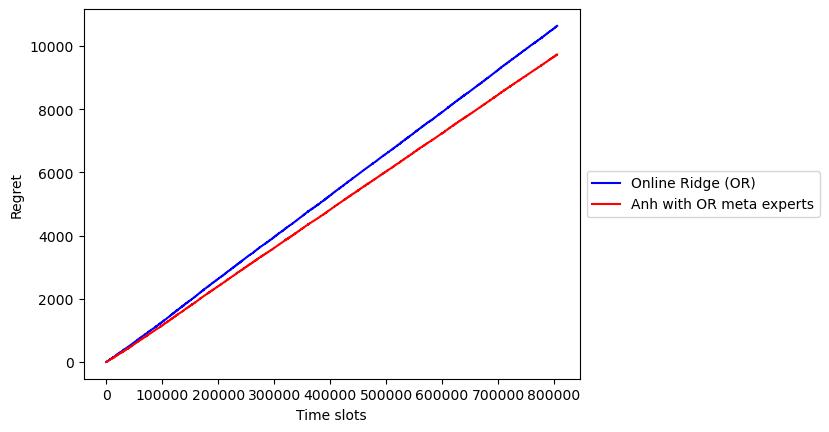

Group number 1, Tg is 763685 

    oridge end regret 8643.141489419555, Anh end regret 8419.842147319374, 

    Anh better Yes 
Oridge regret - Anh regret implementables 223.2993421001811
Relative difference percent 2.6173539968635637


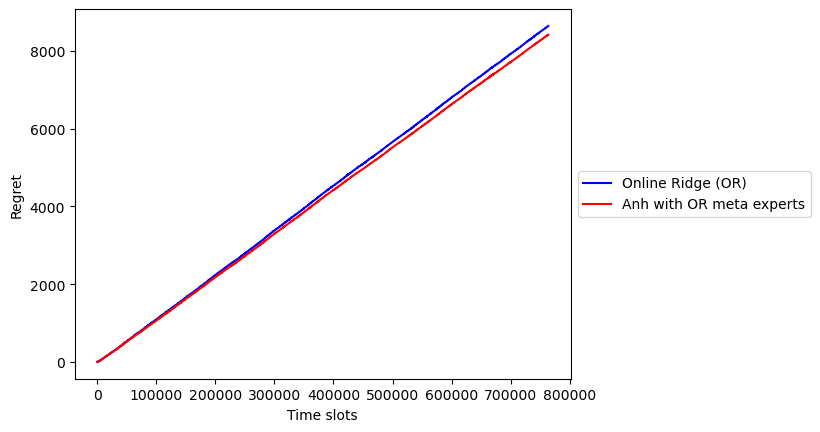

Group number 2, Tg is 1045807 

    oridge end regret 13260.758232793381, Anh end regret 12719.826169744225, 

    Anh better Yes 
Oridge regret - Anh regret implementables 540.9320630491566
Relative difference percent 4.164125445895066


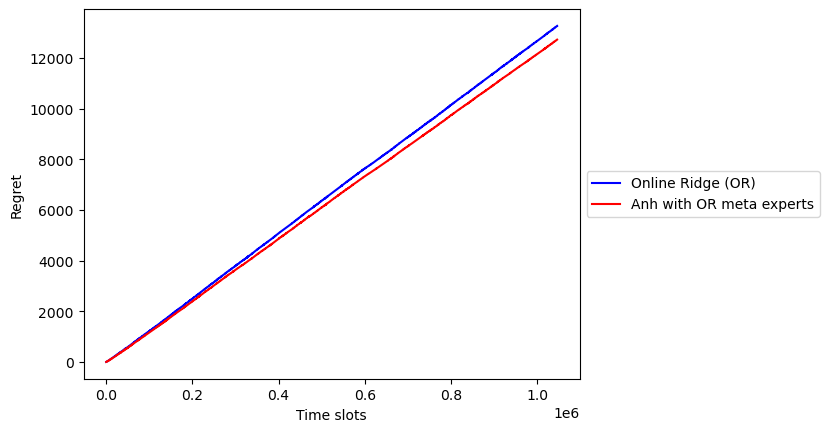

Group number 3, Tg is 136227 

    oridge end regret 1134.271059019918, Anh end regret 1064.3980636457468, 

    Anh better Yes 
Oridge regret - Anh regret implementables 69.8729953741713
Relative difference percent 6.3559354751348245


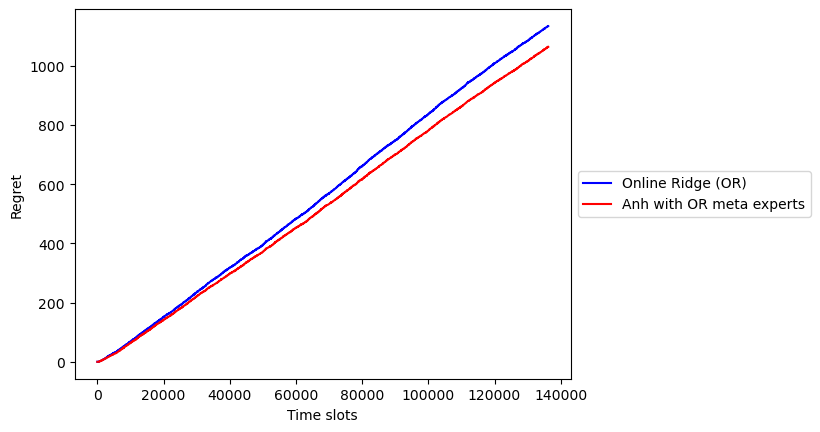

Group number 4, Tg is 14455 

    oridge end regret 86.04737673509885, Anh end regret 71.2692387613622, 

    Anh better Yes 
Oridge regret - Anh regret implementables 14.778137973736648
Relative difference percent 18.787764950446817


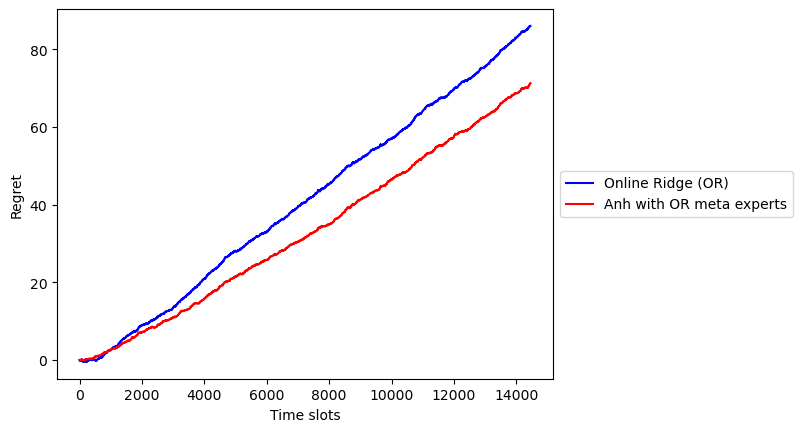

Group number 5, Tg is 726 

    oridge end regret 1.4031296652651193, Anh end regret 1.1912910616522794, 

    Anh better Yes 
Oridge regret - Anh regret implementables 0.2118386036128399
Relative difference percent 16.330320014405622


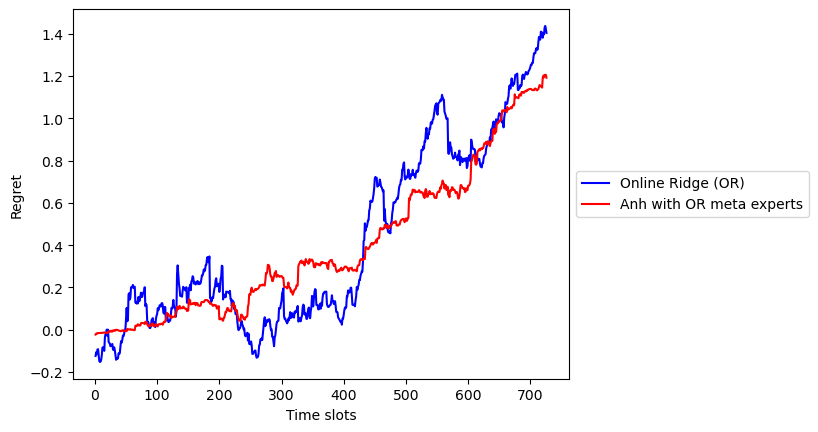

Group number 6, Tg is 2316 

    oridge end regret 13.126594366225724, Anh end regret 9.663408677472042, 

    Anh better Yes 
Oridge regret - Anh regret implementables 3.4631856887536827
Relative difference percent 30.392147663283218


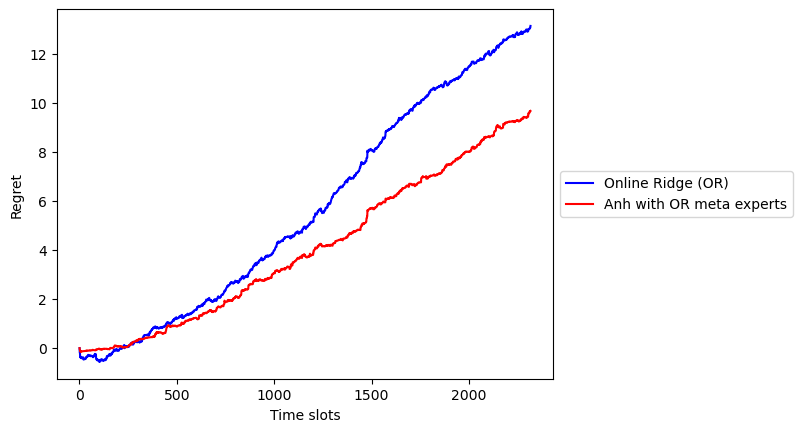

Group number 7, Tg is 100852 

    oridge end regret 2027.3270624123056, Anh end regret 1682.0914247720625, 

    Anh better Yes 
Oridge regret - Anh regret implementables 345.2356376402431
Relative difference percent 18.614003183140117


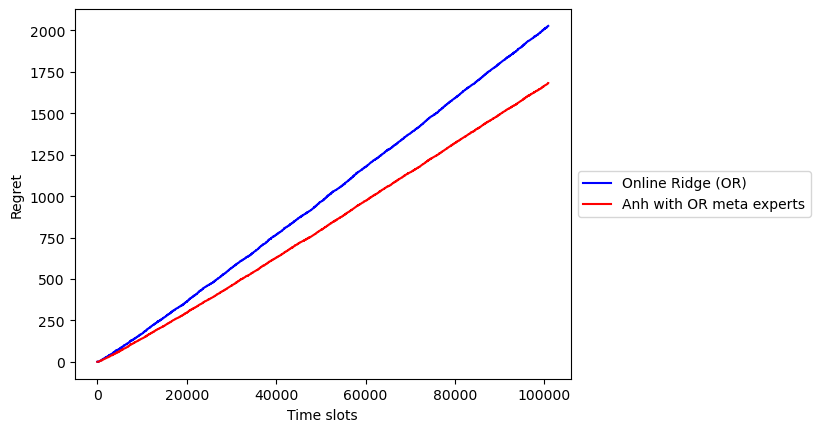

Group number 8, Tg is 2755 

    oridge end regret 10.204610847830722, Anh end regret 11.405812794289034, 

    Anh better No 
Oridge regret - Anh regret implementables -1.201201946458312
Relative difference percent 11.116875507402007


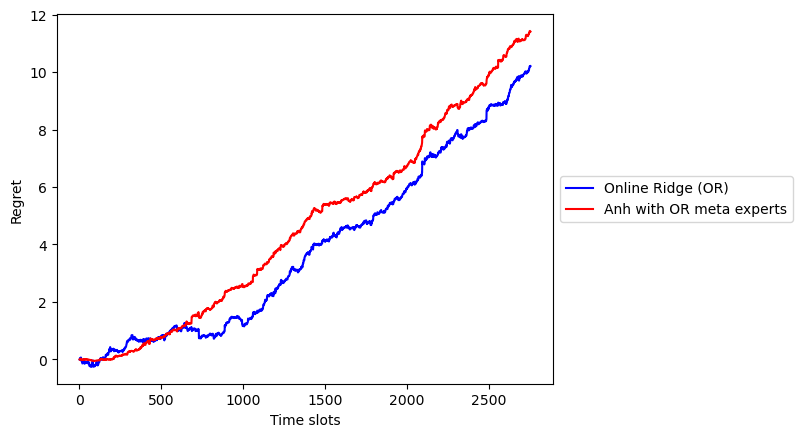

Group number 9, Tg is 97582 

    oridge end regret 724.5682885196945, Anh end regret 600.4649178129191, 

    Anh better Yes 
Oridge regret - Anh regret implementables 124.10337070677542
Relative difference percent 18.732114804920993


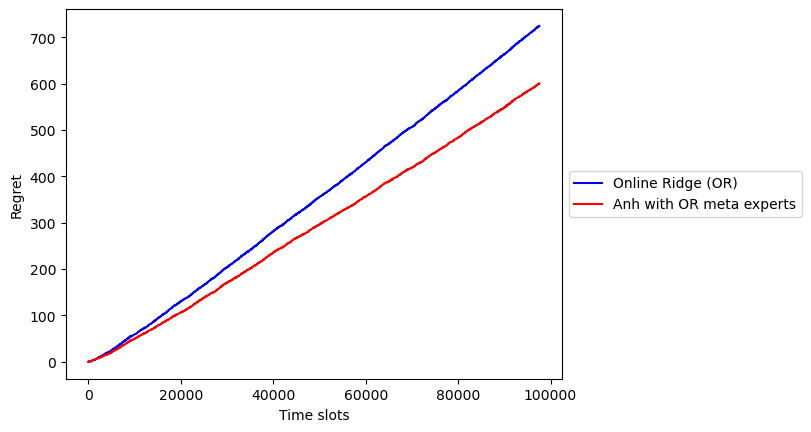

Group number 10, Tg is 168468 

    oridge end regret 1673.0472977946147, Anh end regret 1644.050020912915, 

    Anh better Yes 
Oridge regret - Anh regret implementables 28.99727688169969
Relative difference percent 1.7483524959103796


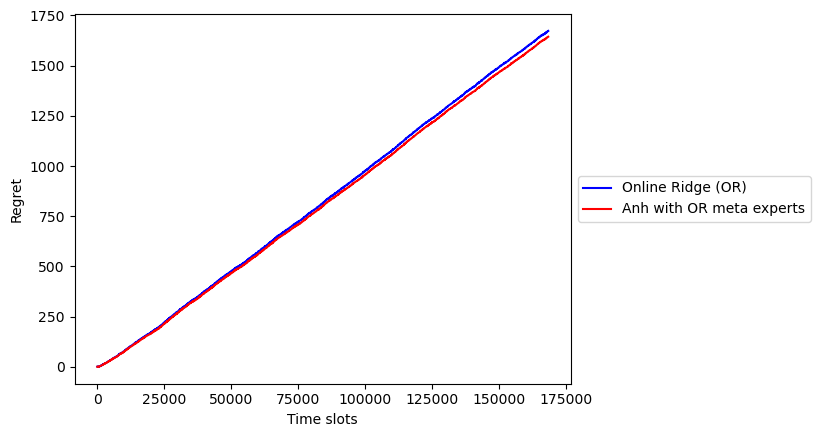

Group number 11, Tg is 1569188 

    oridge end regret 18843.73379641585, Anh end regret 17717.340492446885, 

    Anh better Yes 
Oridge regret - Anh regret implementables 1126.3933039689655
Relative difference percent 6.161707914102997


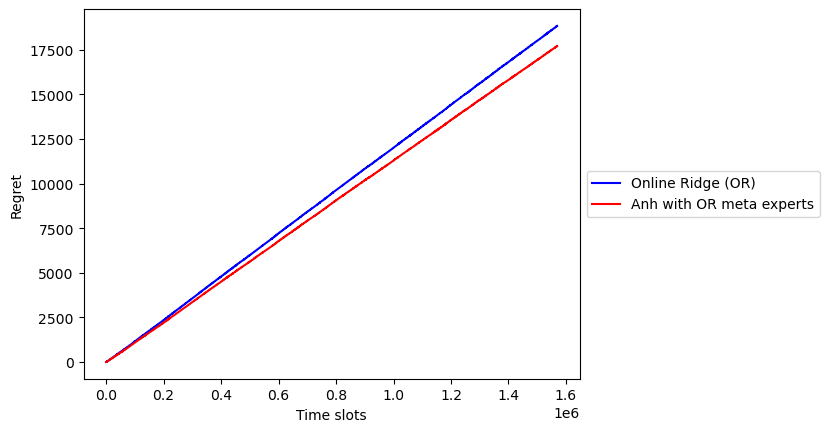

Anh better for 11 out of 12 groups


In [10]:
plot_ORidgevsAnh_together(di_temp['oridge_implementable'].cumreg_groupwise_oridge, di_temp['Anh'])

# shuffed and dropped

In [ ]:
dir = './onehot_encoded/' # head directory for saving results
filename = 'allstates2021_'
groups = ['SEX_1', 'SEX_2', 'RAC1P_1','RAC1P_2','RAC1P_3','RAC1P_4','RAC1P_5','RAC1P_6', 'RAC1P_7','RAC1P_8','RAC1P_9']

alm_obj = All_linear_models(dir, filename, data_fil, cat_cols_sig, groups)
di_temp = {}
di_temp['bls'] = 1
di_temp['Anh'] = 2
di_temp['oridge_implementable'] = 3
alm_obj.build_models(di_to_fill = di_temp, to_shuffle = True, to_drop_groups = True)

# state by state and dropped 

In [7]:
dir = './onehot_encoded/' # head directory for saving results
filename = 'allstates2021_'
groups = ['SEX_1', 'SEX_2', 'RAC1P_1','RAC1P_2','RAC1P_3','RAC1P_4','RAC1P_5','RAC1P_6', 'RAC1P_7','RAC1P_8','RAC1P_9']

alm_obj = All_linear_models(dir, filename, data_fil, cat_cols_sig, groups)
di_temp2 = {}
di_temp2['bls'] = 1
di_temp2['Anh'] = 2
di_temp2['oridge_implementable'] = 3
alm_obj.build_models(di_to_fill = di_temp2, to_shuffle=False, to_drop_groups = True)

/Users/krisacha/Documents/multigroupcode/multigroup-code/build_all_models.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_tdf['alwayson'] = 1 # adds the always active / using all data "group"
100%|██████████| 1569188/1569188 [14:00<00:00, 1866.24it/s]


In [8]:
di_temp2

{'bls': <bestLS_hindsight_together.BestLS_Hindsight_Together at 0x6e1324c10>,
 'Anh': <lean_adahedge.Adanormal_sleepingexps at 0x6203bf550>,
 'oridge_implementable': <oridge_alwaysactive_implementable.OnlineRidgeImplementable_alwaysactive at 0x694a2cb10>,
 'A_t': array([[0, 1, 1, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 0, 1],
        [0, 1, 1, ..., 0, 0, 1],
        ...,
        [0, 1, 0, ..., 0, 1, 1],
        [1, 0, 0, ..., 0, 1, 1],
        [0, 1, 0, ..., 0, 0, 1]])}

Group number 0, Tg is 805503 

    oridge end regret 10770.921875205655, Anh end regret 9329.174098254873, 

    Anh better Yes 
Oridge regret - Anh regret implementables 1441.7477769507823
Relative difference percent 14.345680526644413


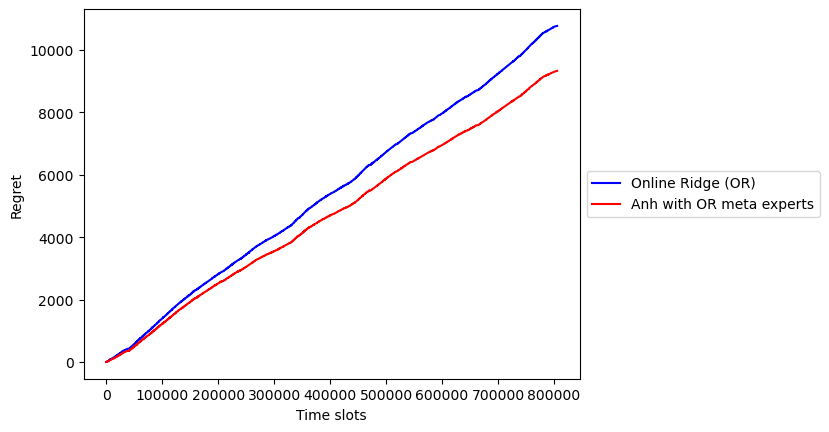

Group number 1, Tg is 763685 

    oridge end regret 8985.724128644457, Anh end regret 8117.497661586129, 

    Anh better Yes 
Oridge regret - Anh regret implementables 868.2264670583281
Relative difference percent 10.152782647702807


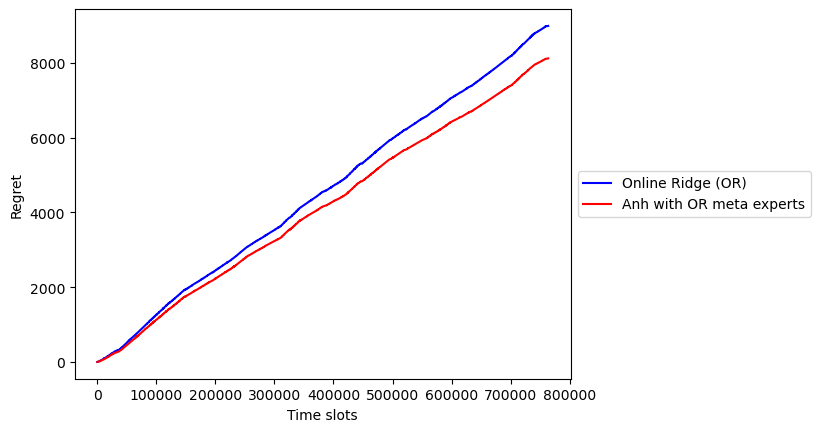

Group number 2, Tg is 1045807 

    oridge end regret 13334.932066637826, Anh end regret 11819.207499803524, 

    Anh better Yes 
Oridge regret - Anh regret implementables 1515.724566834302
Relative difference percent 12.051492064204503


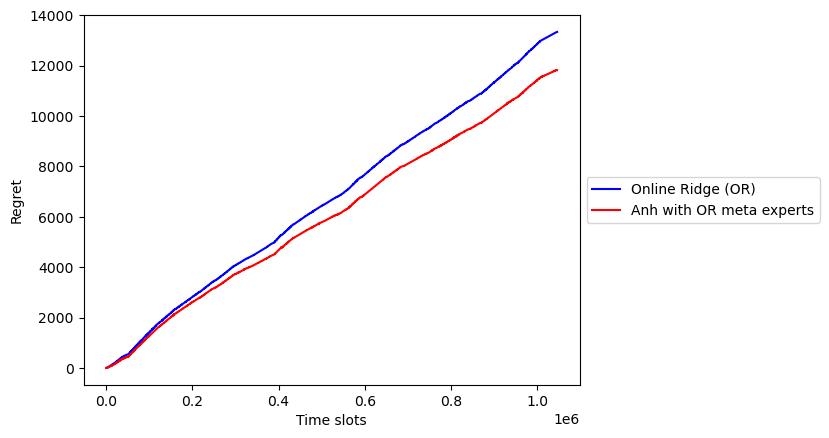

Group number 3, Tg is 136227 

    oridge end regret 1070.6763858050608, Anh end regret 938.2136115975136, 

    Anh better Yes 
Oridge regret - Anh regret implementables 132.46277420754723
Relative difference percent 13.18765829675264


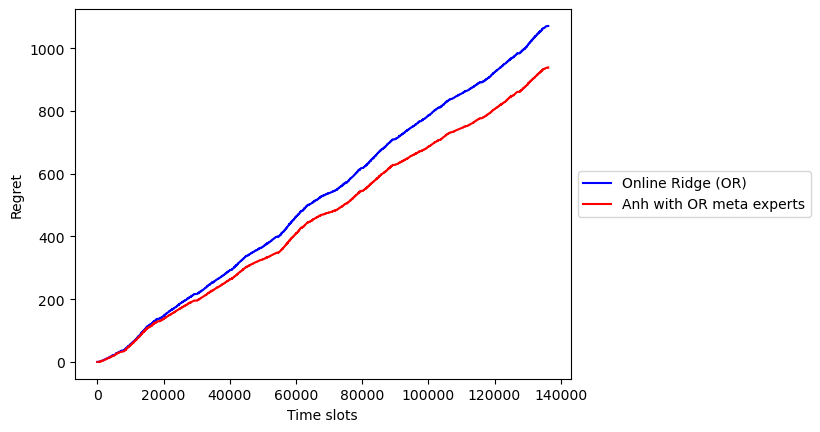

Group number 4, Tg is 14455 

    oridge end regret 91.08333657619607, Anh end regret 71.14291397705256, 

    Anh better Yes 
Oridge regret - Anh regret implementables 19.940422599143517
Relative difference percent 24.58347219533171


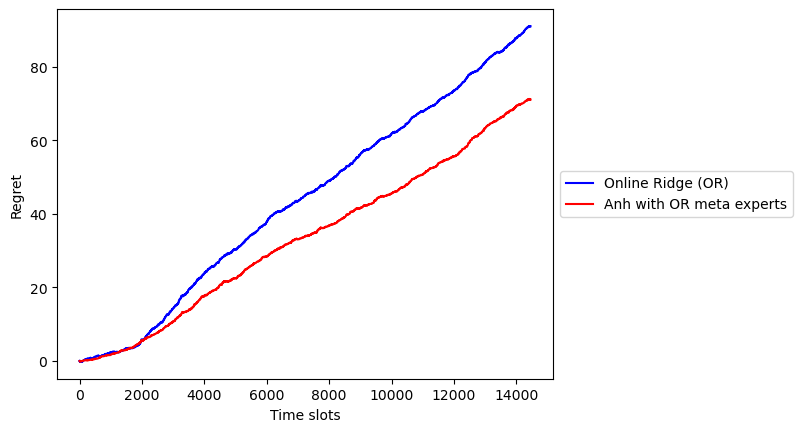

Group number 5, Tg is 726 

    oridge end regret 2.506860615783335, Anh end regret 1.236417284328052, 

    Anh better Yes 
Oridge regret - Anh regret implementables 1.270443331455283
Relative difference percent 67.87865423603623


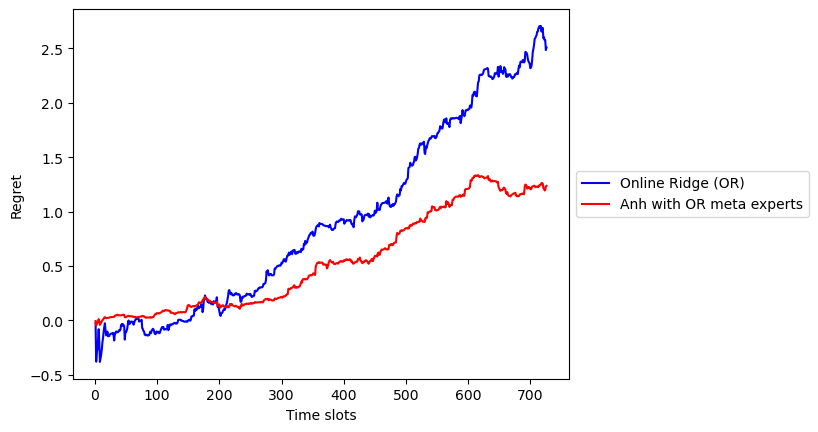

Group number 6, Tg is 2316 

    oridge end regret 13.673292294954265, Anh end regret 8.360966262935214, 

    Anh better Yes 
Oridge regret - Anh regret implementables 5.312326032019051
Relative difference percent 48.21878637815063


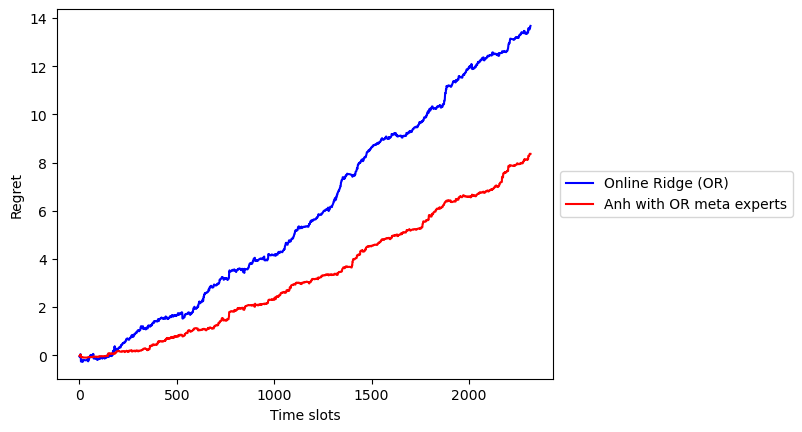

Group number 7, Tg is 100852 

    oridge end regret 1856.5460991641944, Anh end regret 1592.730306001646, 

    Anh better Yes 
Oridge regret - Anh regret implementables 263.8157931625483
Relative difference percent 15.296877499723834


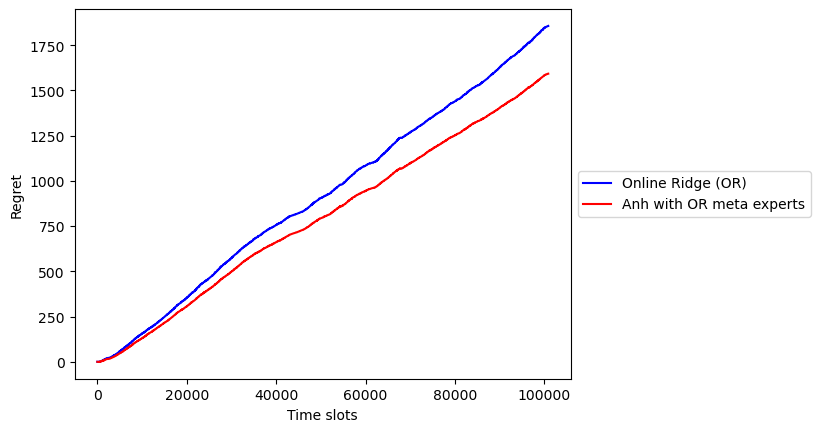

Group number 8, Tg is 2755 

    oridge end regret 13.244923229140312, Anh end regret 9.582714933839327, 

    Anh better Yes 
Oridge regret - Anh regret implementables 3.662208295300985
Relative difference percent 32.08573983129025


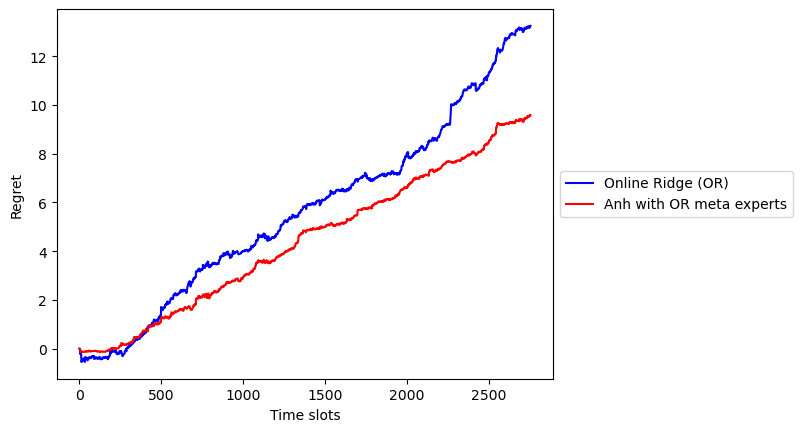

Group number 9, Tg is 97582 

    oridge end regret 860.3519277608511, Anh end regret 606.158381816108, 

    Anh better Yes 
Oridge regret - Anh regret implementables 254.19354594474316
Relative difference percent 34.666451955331944


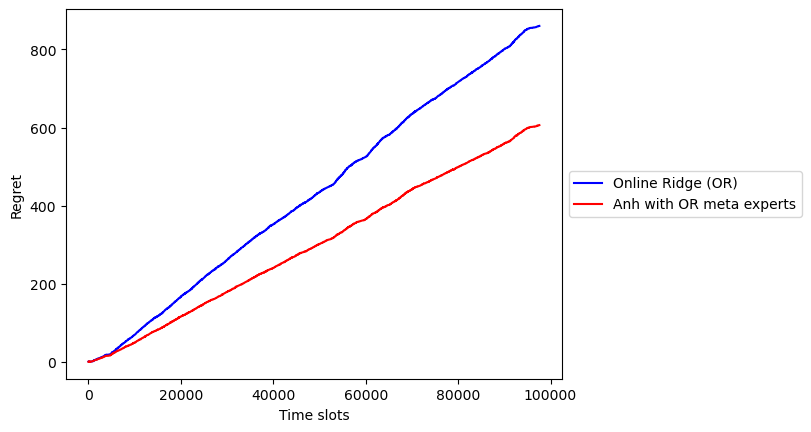

Group number 10, Tg is 168468 

    oridge end regret 1775.3948544313912, Anh end regret 1661.8026908302322, 

    Anh better Yes 
Oridge regret - Anh regret implementables 113.59216360115897
Relative difference percent 6.609580165548086


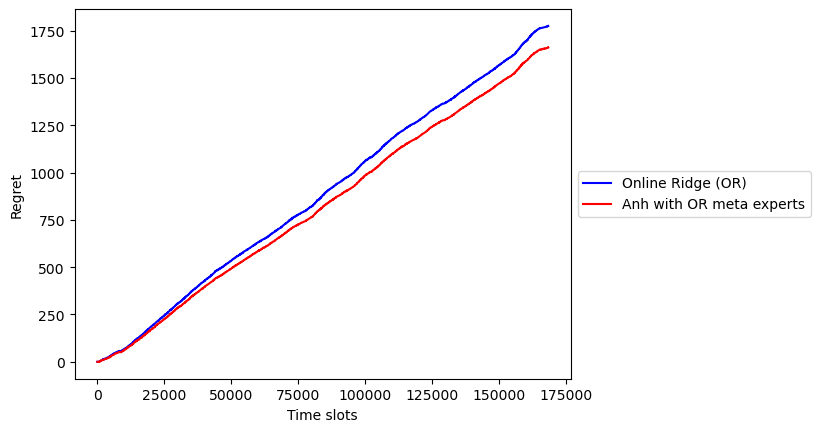

Group number 11, Tg is 1569188 

    oridge end regret 18981.551018925325, Anh end regret 16671.576774916066, 

    Anh better Yes 
Oridge regret - Anh regret implementables 2309.9742440092596
Relative difference percent 12.958045405532568


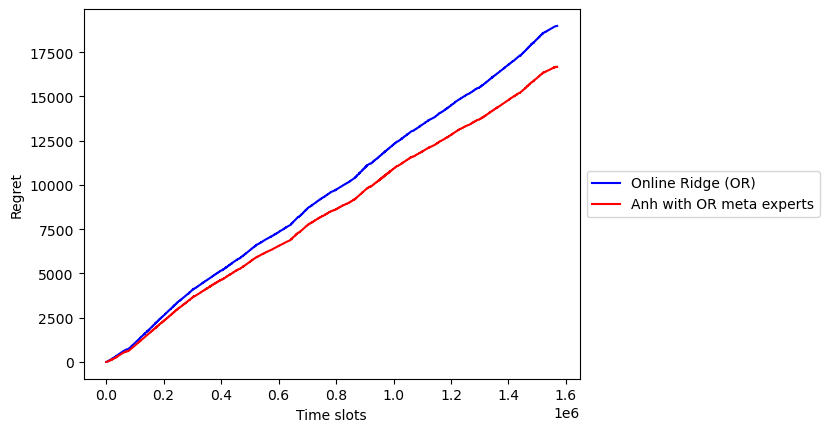

Anh better for 12 out of 12 groups


In [11]:
plot_ORidgevsAnh_together(di_temp2['oridge_implementable'].cumreg_groupwise_oridge, di_temp2['Anh'])